In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import zipfile
import os

zip_path = '/content/drive/MyDrive/ML/Datasets/realwaste.zip'
extract_path = '/content/realwaste_dataset'

# Create extraction folder if it doesn’t exist
os.makedirs(extract_path, exist_ok=True)

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")
print("Extracted to:", extract_path)


✅ Dataset extracted successfully!
Extracted to: /content/realwaste_dataset


In [4]:
import os
import shutil
import random

source_dir = '/content/realwaste_dataset/realwaste-main/RealWaste'
base_dir = '/content/realwaste_split'  # new folder to store the split dataset

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

#Split the data
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # List all images in the class
    images = os.listdir(class_path)
    random.shuffle(images)

    # Compute split indices
    total = len(images)
    train_count = int(split_ratio['train'] * total)
    val_count = int(split_ratio['val'] * total)

    train_imgs = images[:train_count]
    val_imgs = images[train_count:train_count + val_count]
    test_imgs = images[train_count + val_count:]

    # Create subdirectories for the class in train/val/test
    for split, img_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy images to new directories
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

    print(f" {class_name}: {train_count} train, {val_count} val, {len(test_imgs)} test")

print("\n Dataset successfully split into train, val, and test folders!")
print("Root directory:", base_dir)


 Glass: 294 train, 63 val, 63 test
 Cardboard: 322 train, 69 val, 70 test
 Metal: 553 train, 118 val, 119 test
 Food Organics: 287 train, 61 val, 63 test
 Paper: 350 train, 75 val, 75 test
 Plastic: 644 train, 138 val, 139 test
 Miscellaneous Trash: 346 train, 74 val, 75 test
 Vegetation: 305 train, 65 val, 66 test
 Textile Trash: 222 train, 47 val, 49 test

 Dataset successfully split into train, val, and test folders!
Root directory: /content/realwaste_split


In [5]:
#import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import copy
import os


In [6]:
# Splited data path
data_dir = '/content/realwaste_split'


In [7]:
#Preprocessing and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                             [0.229, 0.224, 0.225])  # Imagenet std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [8]:

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print("Classes:", class_names)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [9]:
#loading pretrained resnet 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet50(pretrained=True)

# Freeze earlier layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # number of classes in dataset

model_ft = model_ft.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [10]:
#defined the Loss
criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)


In [11]:
#training
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            # Deep copy the model if best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

model_ft, train_loss, val_loss = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=10)


Epoch 1/10
------------------------------
train Loss: 1.3891 Acc: 0.5417
val Loss: 0.9608 Acc: 0.6775

Epoch 2/10
------------------------------
train Loss: 0.8779 Acc: 0.7117
val Loss: 0.8410 Acc: 0.7127

Epoch 3/10
------------------------------
train Loss: 0.7903 Acc: 0.7397
val Loss: 0.7851 Acc: 0.7197

Epoch 4/10
------------------------------
train Loss: 0.7350 Acc: 0.7475
val Loss: 0.6572 Acc: 0.7845

Epoch 5/10
------------------------------
train Loss: 0.7069 Acc: 0.7577
val Loss: 0.7041 Acc: 0.7493

Epoch 6/10
------------------------------
train Loss: 0.6099 Acc: 0.7969
val Loss: 0.6545 Acc: 0.7690

Epoch 7/10
------------------------------
train Loss: 0.5977 Acc: 0.7960
val Loss: 0.6586 Acc: 0.7690

Epoch 8/10
------------------------------
train Loss: 0.5856 Acc: 0.8086
val Loss: 0.6389 Acc: 0.7915

Epoch 9/10
------------------------------
train Loss: 0.5886 Acc: 0.8095
val Loss: 0.6278 Acc: 0.7944

Epoch 10/10
------------------------------
train Loss: 0.5891 Acc: 0.8002

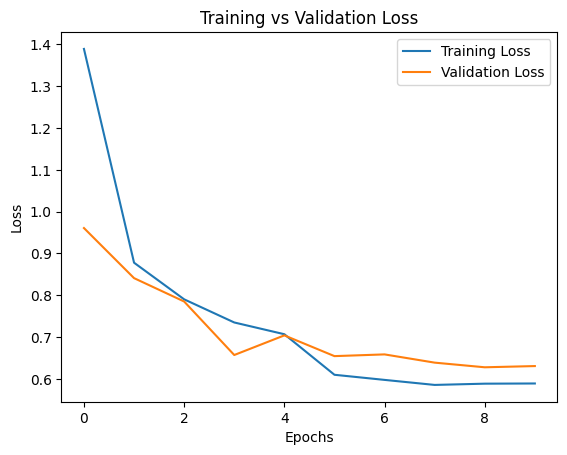

In [12]:

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [13]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/resnet50_waste_finetuned.pth')
print("✅ Model saved to Drive successfully!")


✅ Model saved to Drive successfully!


In [14]:
from google.colab import files

# Save temporarily in Colab
torch.save(model_ft.state_dict(), 'resnet50_realwaste_finetuned.pth')

# Download to your local computer
files.download('resnet50_realwaste_finetuned.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random
import os

#load test dataset
test_dir = '/content/realwaste_split/test'

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
class_names = test_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✅ Classes found:", class_names)



✅ Classes found: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [16]:
# =====================================================
# STEP 2: Recreate model architecture & load weights
# =====================================================
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Load trained weights
model.load_state_dict(torch.load('/content/resnet50_realwaste_finetuned.pth', map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded successfully from /content/resnet50_realwaste_finetuned.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded successfully from /content/resnet50_realwaste_finetuned.pth


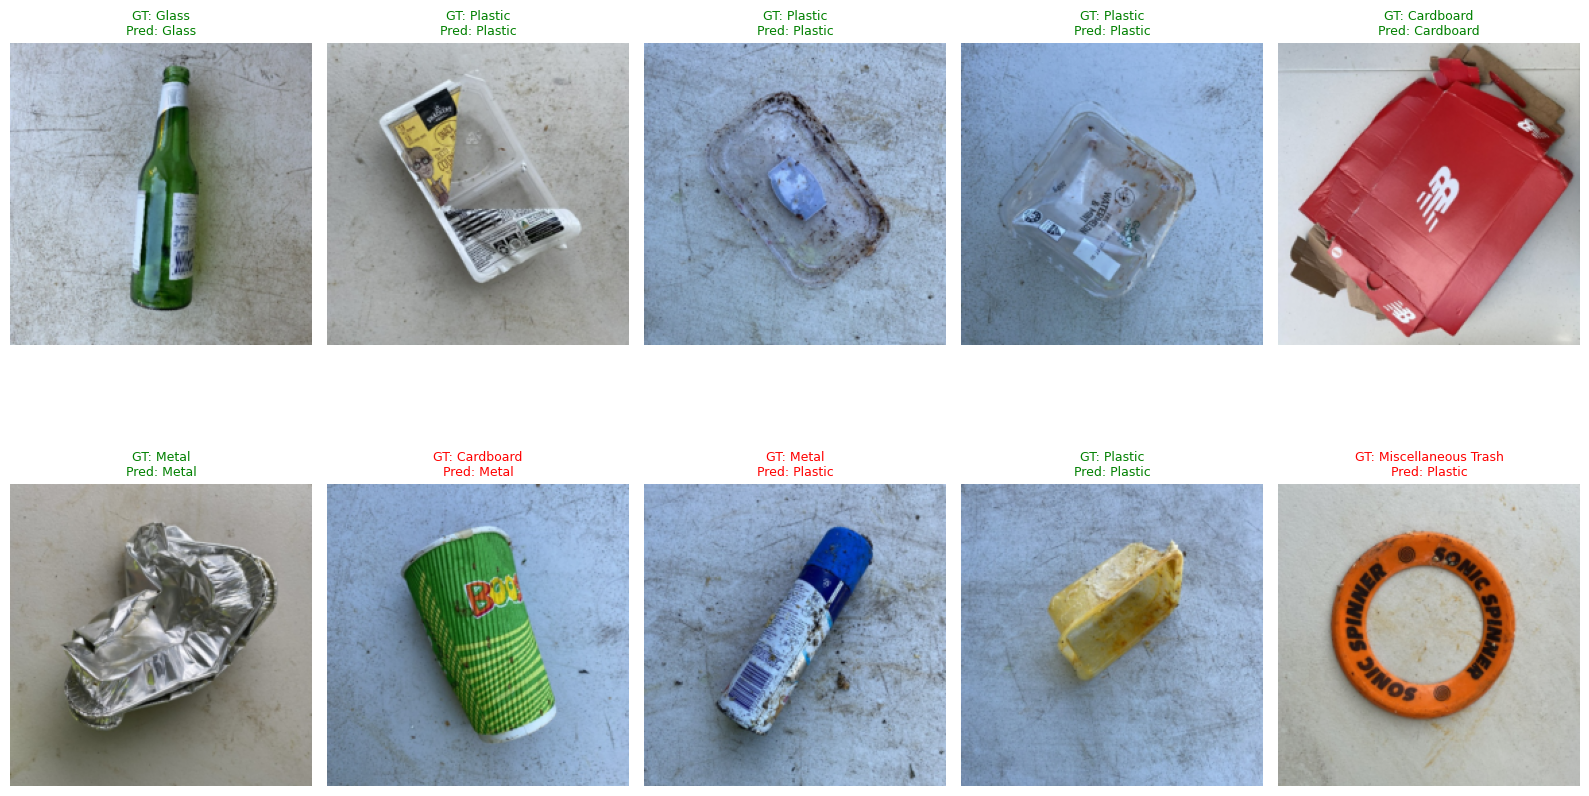

In [17]:
# =====================================================
# STEP 3: Visualize predictions on 10 random test images
# =====================================================
def imshow(inp, title=None):
    """Display an image tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title:
        plt.title(title)

# Pick 10 random test images
samples = random.sample(range(len(test_dataset)), 10)

plt.figure(figsize=(16, 10))
for i, idx in enumerate(samples):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)

    gt_label = class_names[label]
    pred_label = class_names[preds[0]]
    color = 'green' if gt_label == pred_label else 'red'

    plt.subplot(2, 5, i + 1)
    imshow(image.cpu(), title=f"GT: {gt_label}\nPred: {pred_label}")
    plt.title(f"GT: {gt_label}\nPred: {pred_label}", color=color, fontsize=9)

plt.tight_layout()
plt.show()



✅ Test Accuracy of Fine-Tuned ResNet50: 73.85%

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.75      0.71      0.73        70
      Food Organics       0.86      0.90      0.88        63
              Glass       0.74      0.67      0.70        63
              Metal       0.69      0.79      0.74       119
Miscellaneous Trash       0.74      0.37      0.50        75
              Paper       0.84      0.69      0.76        75
            Plastic       0.69      0.77      0.73       139
      Textile Trash       0.61      0.78      0.68        49
         Vegetation       0.84      0.95      0.89        66

           accuracy                           0.74       719
          macro avg       0.75      0.74      0.73       719
       weighted avg       0.74      0.74      0.73       719



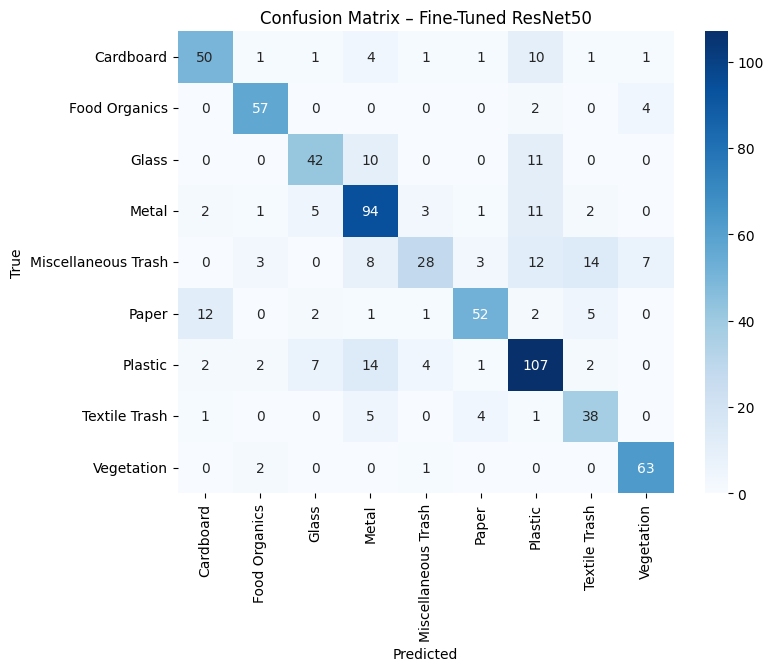

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

# ===============================================
# Evaluate Fine-Tuned ResNet50 on test dataset
# ===============================================
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\n Test Accuracy of Fine-Tuned ResNet50: {acc*100:.2f}%\n")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Fine-Tuned ResNet50")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()
